wlen: 2048 | wstep: 512
['acc_qu_G4_12.wav', 'flt_G4_12.wav', 'sax_G4_12.wav', 'sine-1000.wav', 'clr_G4_12.wav', 'acc_se_G4_12.wav']
-------------------------------------------------------------------------------------------
acc_qu_G4_12.wav 
	N = 280839 samples  | Dur = 6.368231 seconds  | Fs = 44100 Hz


	audata_overwind = (2048, 548) (wlen , nwin)

	ZCR: mean = 0.04131  | std = 0.029563062571141427
	RMS: mean = 0.13635  | std = 0.08198672461810709
	CENTROID: mean = 2064.79074  | std = 464.7472743808413
	SPREAD: mean = 3186.25119  | std = 1000.2190425565286


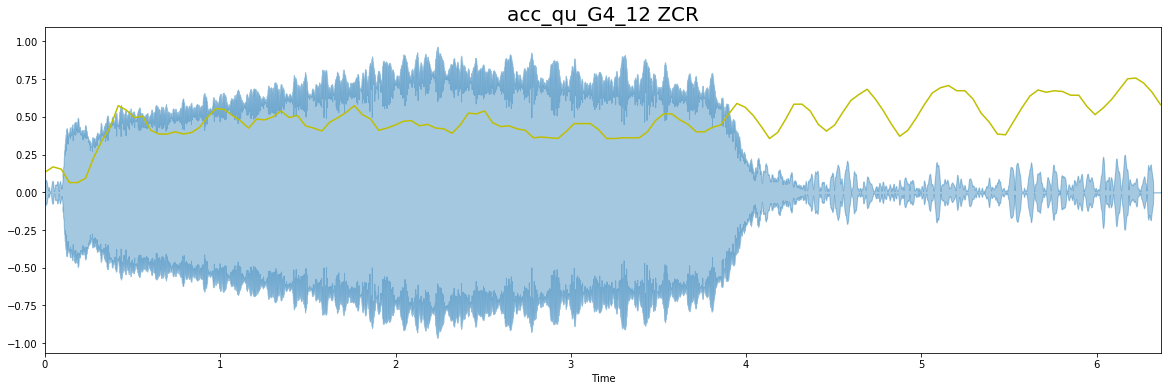

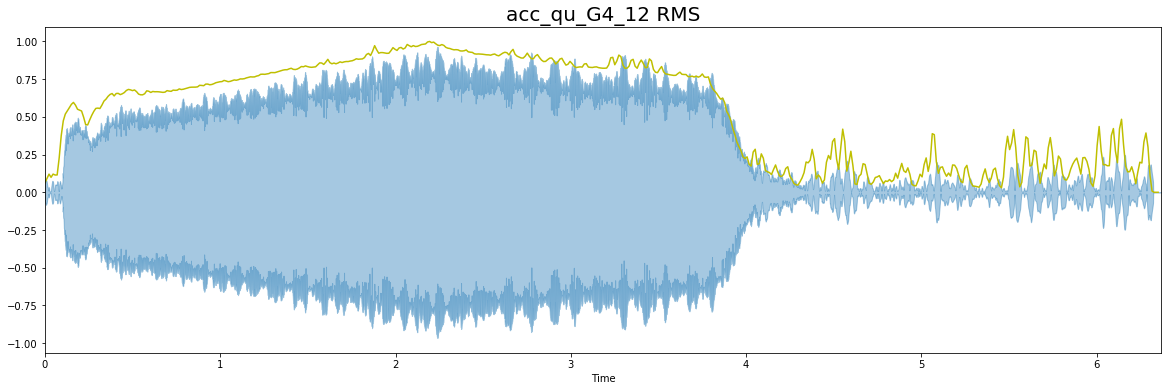

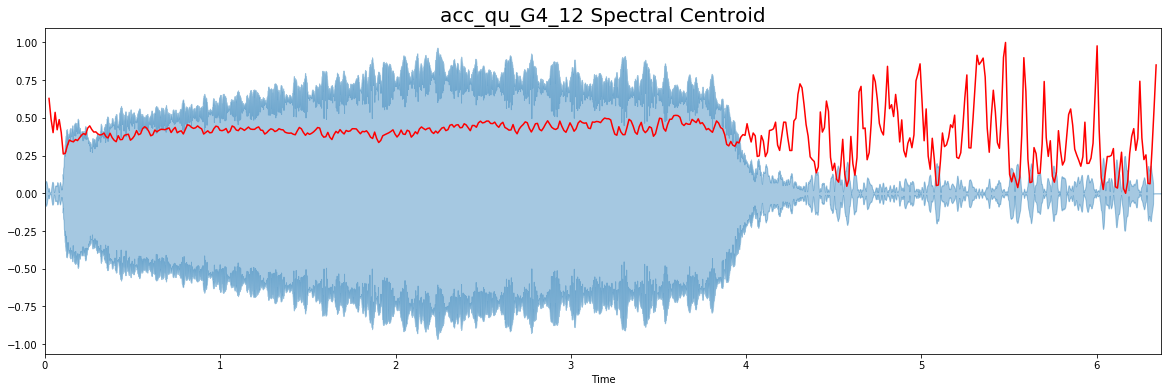

-------------------------------------------------------------------------------------------
flt_G4_12.wav 
	N = 353888 samples  | Dur = 8.024671 seconds  | Fs = 44100 Hz


	audata_overwind = (2048, 688) (wlen , nwin)

	ZCR: mean = 0.03391  | std = 0.006940471398521267
	RMS: mean = 0.29943  | std = 0.14599791739150525
	CENTROID: mean = 1995.52306  | std = 1070.9080865133099
	SPREAD: mean = 3007.99946  | std = 1249.7230241418617


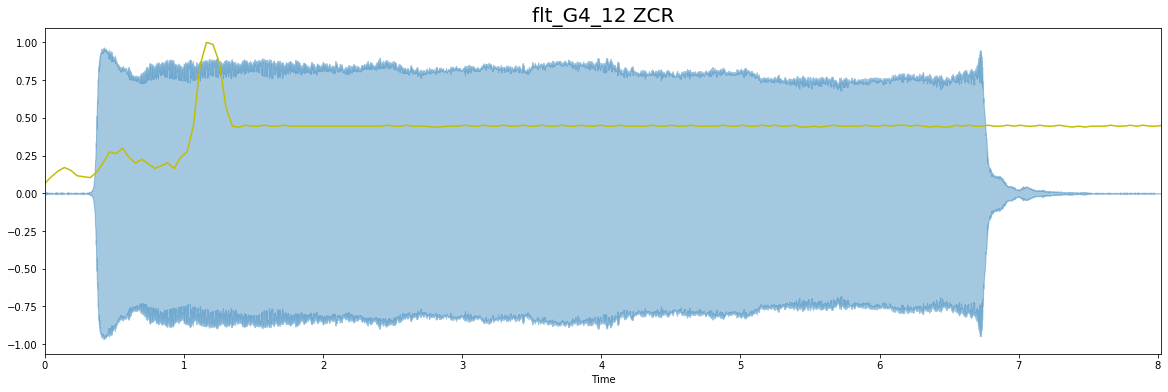

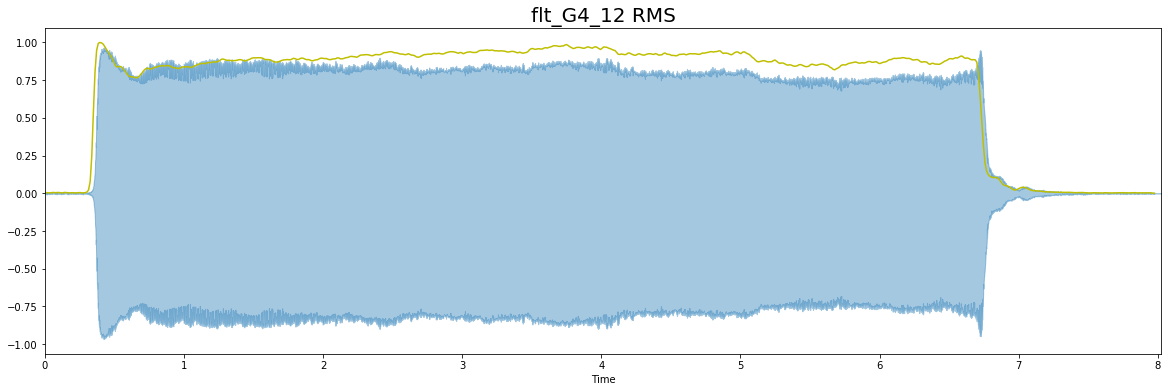

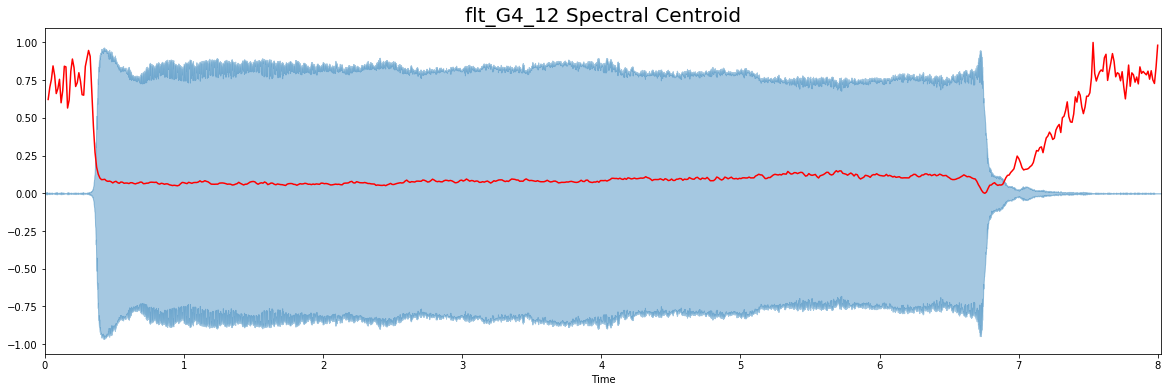

-------------------------------------------------------------------------------------------
sax_G4_12.wav 
	N = 466197 samples  | Dur = 10.571361 seconds  | Fs = 44100 Hz


	audata_overwind = (2048, 908) (wlen , nwin)

	ZCR: mean = 0.03853  | std = 0.023344122293183528
	RMS: mean = 0.18325  | std = 0.08332359326074947
	CENTROID: mean = 2135.09094  | std = 363.77391492480405
	SPREAD: mean = 3068.78064  | std = 716.6160184115735


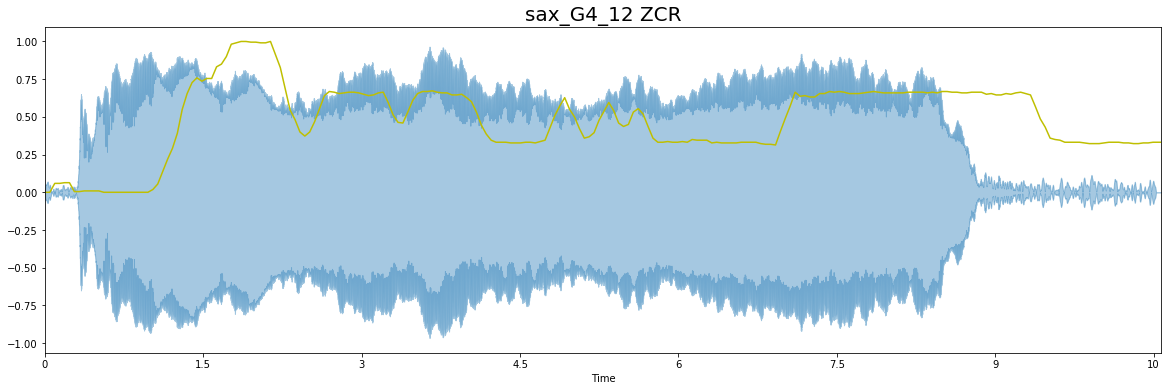

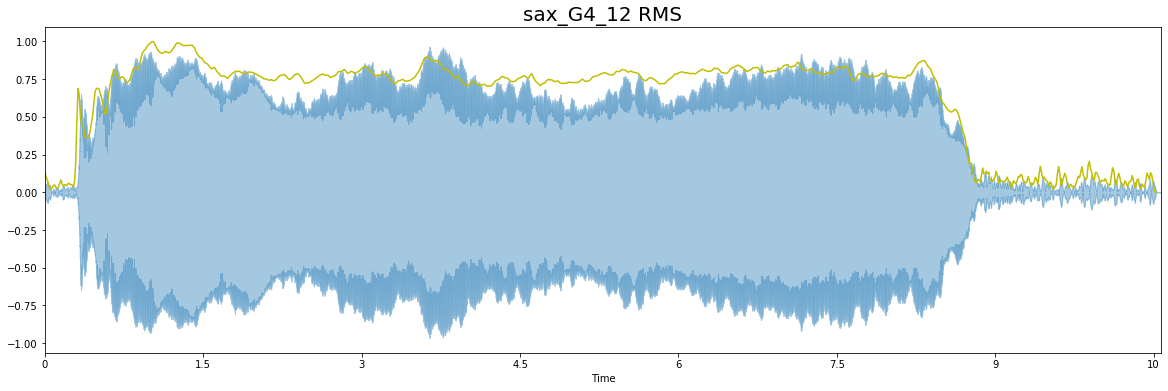

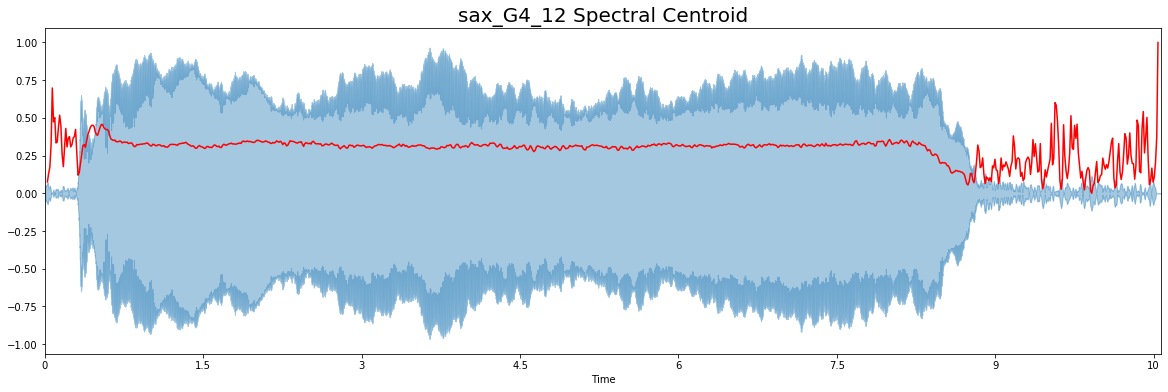

-------------------------------------------------------------------------------------------
sine-1000.wav 
	N = 90248 samples  | Dur = 2.046440 seconds  | Fs = 44100 Hz


	audata_overwind = (2048, 176) (wlen , nwin)

	ZCR: mean = 0.04348  | std = 0.0070694925529409
	RMS: mean = 0.40633  | std = 0.06648174295683593
	CENTROID: mean = 1019.90291  | std = 7.397886600260736
	SPREAD: mean = 584.62825  | std = 26.460090338619082


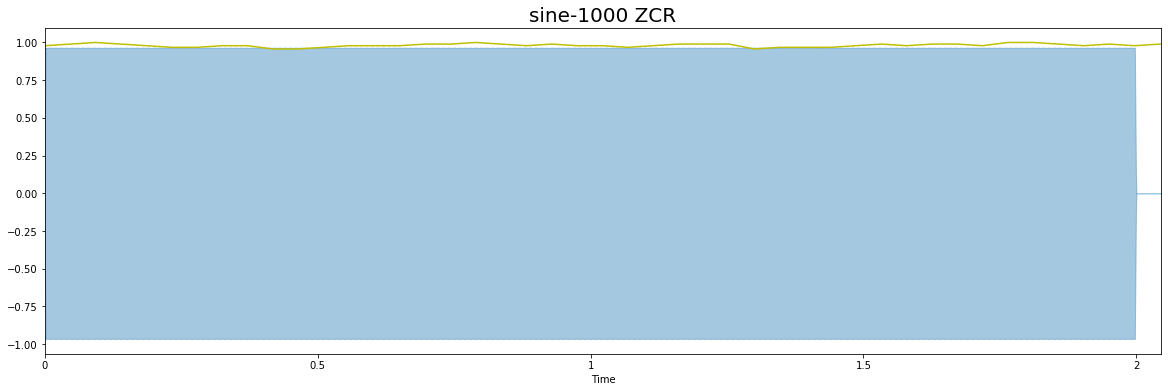

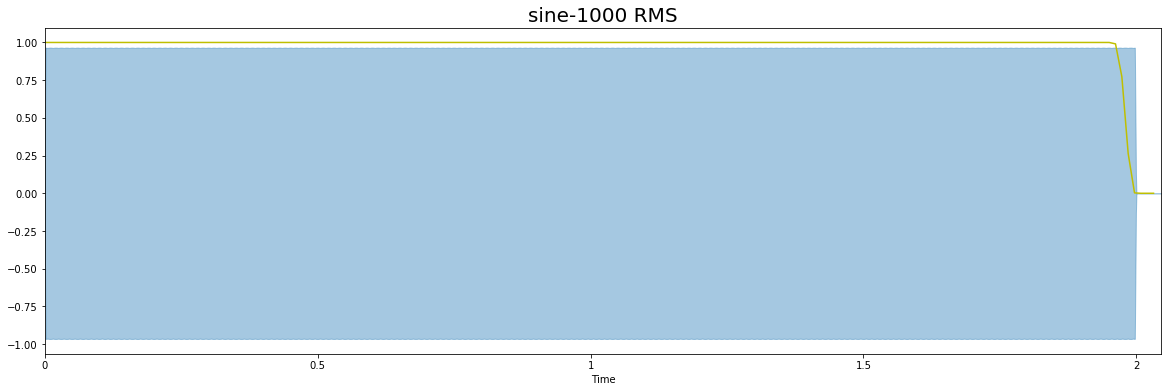

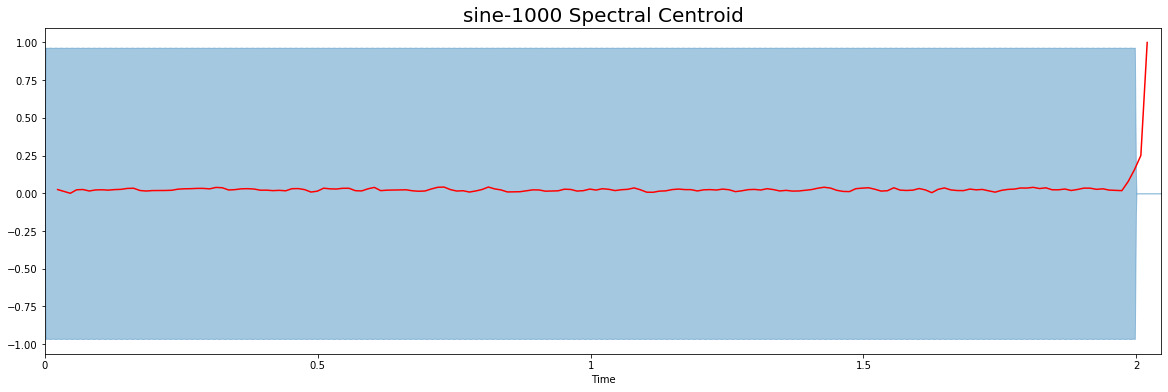

-------------------------------------------------------------------------------------------
clr_G4_12.wav 
	N = 369906 samples  | Dur = 8.387891 seconds  | Fs = 44100 Hz


	audata_overwind = (2048, 720) (wlen , nwin)

	ZCR: mean = 0.03251  | std = 0.01423706913066103
	RMS: mean = 0.17559  | std = 0.09297569605385657
	CENTROID: mean = 2007.77463  | std = 1311.8119576770894
	SPREAD: mean = 2445.90249  | std = 1719.946989271732


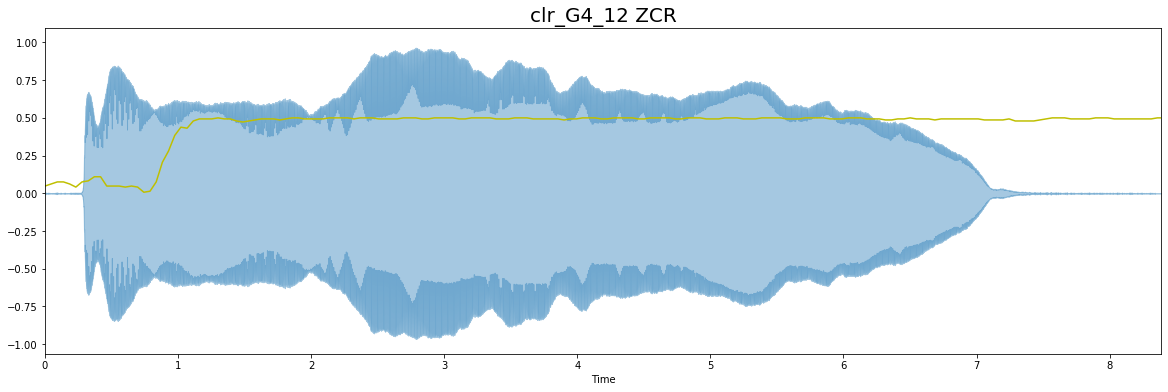

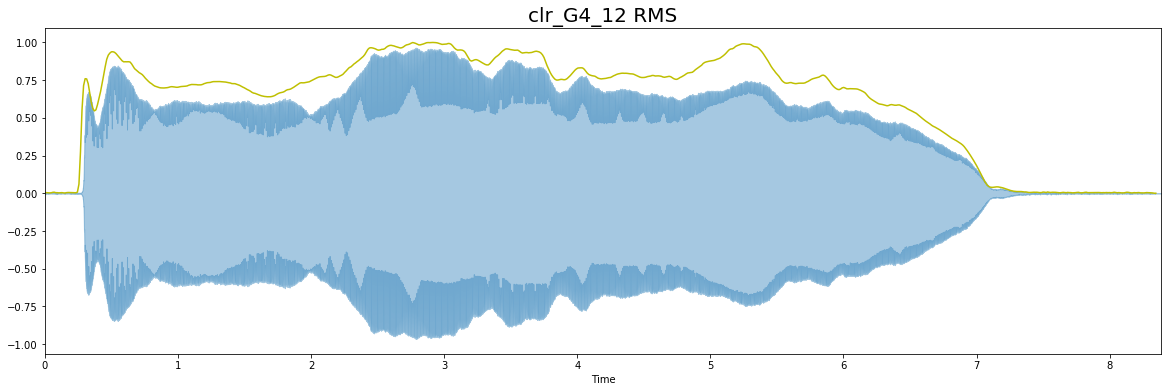

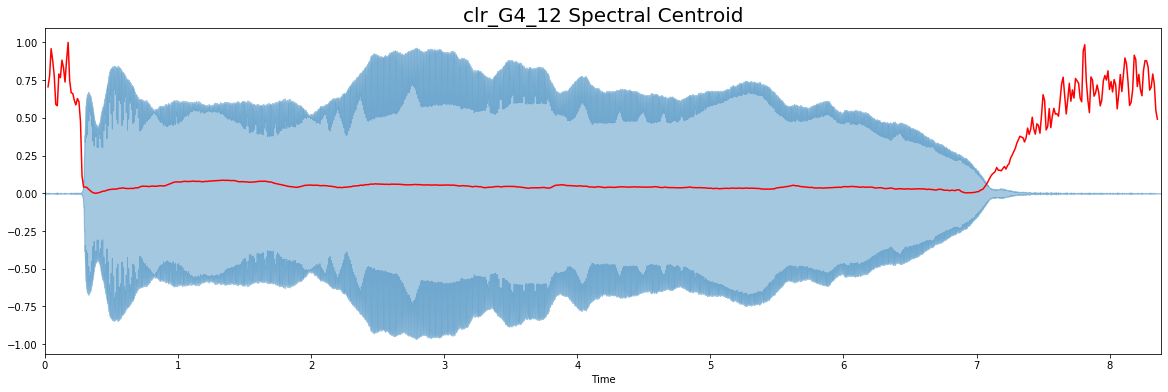

-------------------------------------------------------------------------------------------
acc_se_G4_12.wav 
	N = 255271 samples  | Dur = 5.788458 seconds  | Fs = 44100 Hz


	audata_overwind = (2048, 496) (wlen , nwin)

	ZCR: mean = 0.03094  | std = 0.022157175912021463
	RMS: mean = 0.17484  | std = 0.13052553029691405
	CENTROID: mean = 2356.77128  | std = 523.8224441965551
	SPREAD: mean = 3653.45997  | std = 1122.8766500304805


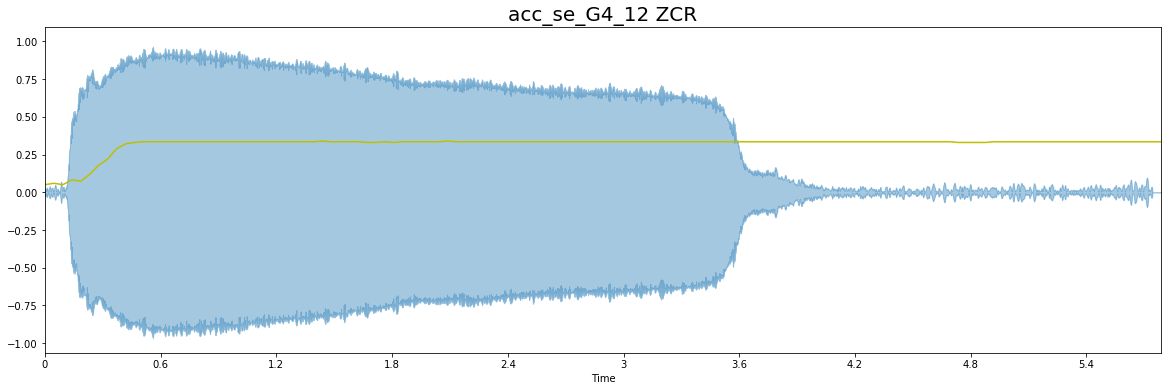

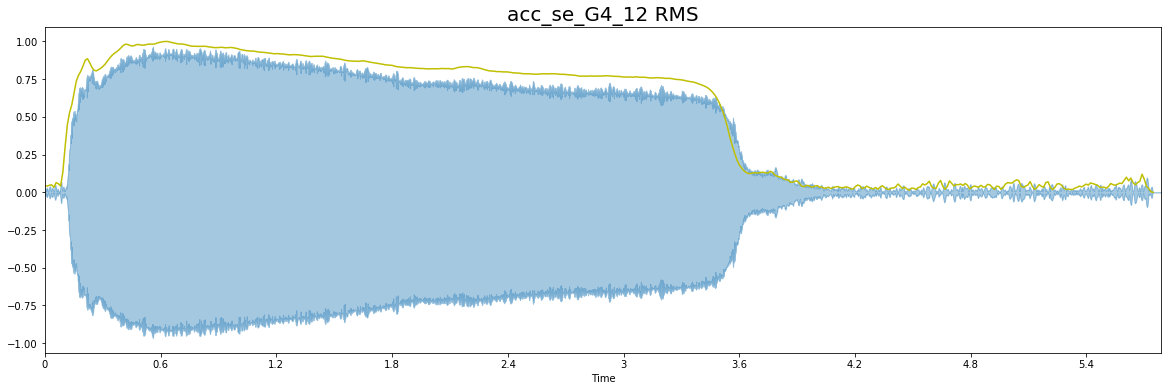

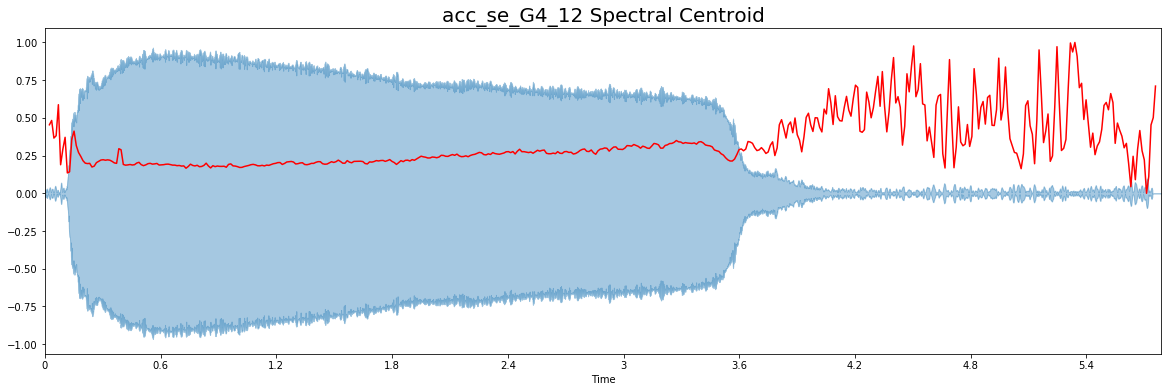

In [11]:
import os
import pyACA
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn import preprocessing
from scipy.signal import spectrogram

from utilvar import utilvar as util



def load_files():
    """Finds and loads files from within folder structure."""
    files = [x for x in os.listdir(util.audio_in_path) if x != '.ipynb_checkpoints']
    return files
     
def load_audio(fwav):
    
    util.f = fwav.split('.',2)[0]
    util.audata , sr = librosa.load(util.audio_in_path + fwav, sr = None )

    #Resample if necessary
    if sr != util.Fs:
        util.audata = librosa.core.resample(util.audata, sr, util.Fs)
    
    ##Normalize if necessary
    #fNorm = np.max(np.abs(util.audata))
    #if fNorm != 0:
    #    util.audata = util.audata / fNorm
    
    #Normalize audio
    util.audata = librosa.util.normalize(util.audata) * librosa.db_to_amplitude(util.max_vol)
    
    # pad with block length zeros just to make sure it runs for weird inputs, too
    util.audata = np.concatenate((util.audata, np.zeros([util.wlen, ])), axis=0)
    
    #Save basic audio information
    util.N = np.shape(util.audata)[0]
    util.dur = util.N / util.Fs
    util.t = np.arange(util.N) / util.Fs #fs = nsamples / segundo
    
    
    
def overlap_n_window():
    window_len, window_step = map(int, (util.wlen, util.wstep))
    if window_len % 2 != 0:
        raise ValueError("Window size must be even!")
    
    X = util.audata
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_len - len(X) % window_len)) #478
    X = np.hstack((X, append)) #22050 + 478 = 22528 ; len(X) multiplo de util.w.len
    
    ws = window_len
    ss = window_step
    a = X

    valid = len(a) - ws #retira a primeira janela
    nw = (valid) // ss #n janelas que vai iterar
    X_win = np.ndarray((ws,nw),dtype = a.dtype)
    
    print("\taudata_overwind =" , np.shape(X_win) , "(wlen , nwin)")
    
    for i in range(nw):
        start = i * ss
        stop = start + ws
        #get X windowed / 1 janela por coluna
        X_win[:,i] = a[start : stop] * util.w
    
    util.audata_overwin = X_win
    util.nwin = nw
    
def normalize(x, axis=0):
    """It takes an array in as an input and normalizes its values between 0 and 1."""
    return sklearn.preprocessing.minmax_scale(x, axis=axis)



def zcr_generate():
    zcr = np.zeros( util.nwin );
    zcr2 = np.zeros( util.nwin );

    #zero_crossings = numpy.where(numpy.diff(numpy.sign(a)))[0] outputs array with indices where it crossed
    x = util.audata_overwin

    for i in range(util.nwin):

        zcr_cont = 0
        for j in range(np.shape(x)[0] - 1): #np.shape(x)[0] = window_len
            if x[j,i] * x[j+1,i] < 0 :
                zcr_cont = zcr_cont + 1
                
        zcr[i] = zcr_cont / util.wlen
        zcr2[i] = np.sum(np.diff(np.sign(x[:,i])) != 0, axis=0) / util.wlen

    util.ft.zcr = zcr

def zcr_plot():
    #MINE
    frames = range(len(util.ft.zcr))
    t_zcr = librosa.frames_to_time(frames, sr = util.Fs , hop_length=util.wlen)
    
    plt.figure(figsize=(20,6))
    plt.title(util.f + " ZCR", fontsize=20)
    librosa.display.waveplot(util.audata, sr=util.Fs, alpha=0.4) #Plot the spectral centroid along with the waveform:
    plt.plot(t_zcr,normalize(util.ft.zcr),color='y',label='og method 1')

    
    
def rms_generate():
    x = util.audata_overwin
    rms = np.zeros( util.nwin);
    
    for i in range(util.nwin):
        rms[i] = np.sqrt(np.mean(x[:,i]**2))
       
    util.ft.rms = rms

def rms_lib_replica_generate():
    rmse = []
    # calculate rmse for each frame
    for i in range(0, len(util.audata), util.wstep): 
        rmse_current_frame = np.sqrt(sum(util.audata[i:i+util.wlen]**2) / util.wlen)
        rmse.append(rmse_current_frame)
    return np.array(rmse) 

def rms_plot(rms_lib = False):
    
    frames = range(len(util.ft.rms))
    t_rms = librosa.frames_to_time(frames, sr = util.Fs , hop_length=util.wstep)
    
    plt.figure(figsize=(20,6))
    plt.title(util.f + " RMS", fontsize=20)
    librosa.display.waveplot(util.audata, sr=util.Fs, alpha=0.4) #Plot the spectral centroid along with the waveform:
    plt.plot(t_rms,normalize(util.ft.rms),color='y',label='rms')
    #db
    #plt.plot(t_rms, 10*np.log(rms) , color='g') PLOT XSCALE IN LOG
   
    plt.savefig(''.join([util.img_out_path, util.f, '_rms.png']), format='png')

    if rms_lib:
        rms_lr = rms_lib_replica_generate()
        
        #RMS LIBROSA REPLICA
        framess = range(len(rms_lr))
        t_rmss = librosa.frames_to_time(framess, sr = util.Fs , hop_length=util.wstep)
        plt.plot(t_rmss,rms_lr,color='b',label='librosa mimica')
        plt.legend(loc='best')

        #LIBROSA
        rms_lib = librosa.feature.rms(util.audata , frame_length = util.wlen , hop_length = util.wstep)[0]
        frames = range(len(rms_lib))
        t_lib = librosa.frames_to_time(frames, sr = util.Fs , hop_length=util.wstep)
        plt.plot(t_lib,rms_lib,color='r',label='librosa')
        plt.legend(loc='best')    


        
def moving_average(a, n=30):
    """Creates a moving average to apply smoothing to the spectral centroid plot."""
    #self.window = n
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
        
    return ret[n - 1:] / n

def centroid_plot(mel = False ,  db = False):
    """Plots the spectral centroid over a db/mel spectrogram or over the waveform """
    
    plt.figure(figsize=(20,6))
    plt.title(util.f + " Spectral Centroid", fontsize=20)
    librosa.display.waveplot(util.audata, sr=util.Fs, alpha=0.4) #Plot the spectral centroid along with the waveform:
    plt.plot(util.spec.t, normalize(util.ft.cntr), color='r') # normalize for visualization purposes
    
    plt.savefig(''.join([util.img_out_path, util.f, '_centroid.png']), format='png')

    if mel or db:  
        spec_cent = moving_average(util.ft.cntr)
        times = librosa.times_like(spec_cent)
    
    #MEL
    if mel: 
        fig, ax = plt.subplots(figsize=(20,10))
        
        S = librosa.feature.melspectrogram(y=util.audata , sr=util.Fs, n_mels=128,fmax=20000)
        S_dB = librosa.power_to_db(S, ref=np.max)
        img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=util.Fs,fmax=20000, ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        
        ax.plot(times, spec_cent.T, label=' Spectral centroid', color='k')
        ax.set(title=f'Mel-frequency spectrogram {util.f}')
        
        #plt.savefig(''.join([util.img_out_path, util.f , '_mel_centroid.png']), format='png')

    #DB
    if db:
        fig, ax = plt.subplots(figsize=(20,10))
        
        D = librosa.stft(y=util.audata , n_fft=util.wlen, hop_length=util.wstep)
        S, phase = librosa.magphase(D)
        librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),sr=util.Fs,
                                 y_axis='log', x_axis='time', ax=ax)
        
        ax.plot(times, spec_cent.T, label=' Spectral centroid', color='k')
        ax.legend(loc='upper right')
        ax.set(title=f'log Power spectrogram {util.f}')

        #plt.savefig(''.join([util.img_out_path, util.f, '_db_centroid.png']), format='png')        
        
        
        
def main():
    
    #Load all audio fn into array 
    files = load_files()
    
    #HannWindow
    util.w = np.hanning(util.wlen)
    
    print("wlen:",util.wlen,
          "| wstep:",util.wstep,
          files )
    
    for fwav in files:
        print('-------------------------------------------------------------------------------------------')
        
        #Process and load data from audio and print basic info
        load_audio(fwav)
        print(fwav,
              "\n\tN = %d samples" %util.N , 
              " | Dur = %f seconds" %util.dur , 
              " | Fs = %d Hz" %util.Fs)
        
        #Display playback
        ipd.display(ipd.Audio( util.audio_in_path + fwav , rate = util.Fs))
        
        #Prepare audata matrix to ZCR and RMS calculus
        overlap_n_window()  
        
        #ZCR
        zcr_generate()
        zcr_plot()
        zcr_mean = np.around(np.mean(util.ft.zcr) , decimals=5)
        zcr_std = np.std(util.ft.zcr)
        print("\n\tZCR: mean =" , zcr_mean , 
              " | std =" , zcr_std )
        
        #RMS
        rms_generate()
        rms_plot()
        rms_mean = np.around(np.mean(util.ft.rms) , decimals=5)
        rms_std = np.std(util.ft.rms)
        print("\tRMS: mean =" , rms_mean ,
              " | std =" , rms_std )
        
        
        #Spectral side of life
        [util.spec.f, util.spec.t, X] = spectrogram(util.audata,
                                                              fs=util.Fs,
                                                              window=util.w,
                                                              nperseg=util.wlen,
                                                              noverlap=util.wlen - util.wstep,
                                                              nfft=util.wlen,
                                                              detrend=False,
                                                              return_onesided=True,
                                                              scaling='spectrum')
        
        #We just want the magnitude spectrum...
        util.spec.X = np.sqrt(X / 2)
        
        
        #SPECTRAL CENTROID
        util.ft.cntr = pyACA.FeatureSpectralCentroid(util.spec.X, util.Fs) #output the vector
        centroid_mean = np.around(np.mean(util.ft.cntr) , decimals=5)
        centroid_std = np.std(util.ft.cntr)
        centroid_plot()
        print("\tCENTROID: mean =" , centroid_mean ,
              " | std =" , centroid_std )
    
        #SPECTRAL SPREAD
        util.ft.sprd = pyACA.FeatureSpectralSpread(util.spec.X, util.Fs)
        sprd_mean = np.around(np.mean(util.ft.sprd) , decimals=5)
        sprd_std = np.std(util.ft.sprd)
        #centroid_plot(mel=True)
        print("\tSPREAD: mean =" , sprd_mean ,
              " | std =" , sprd_std )
        
        
        #SPECTRAL FLUX
        #SPECTRAL FLATNESS
         
        plt.show()

if __name__ == '__main__':
    main()